#نصب کتابخانه های مورد نیاز
پس از نصب نیاز به بارگذاری دوباره ی ران تام خواهید داشت.

In [1]:
#!pip install torchtext==0.16.0
#!pip install portalocker>=2.0.0

# بخش اول: پیاده‌سازی ماژول Attention



In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class SelfAttention(nn.Module):
    def __init__(self, d_model, d_k, d_v):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(d_model, d_k)
        self.key = nn.Linear(d_model, d_k)
        self.value = nn.Linear(d_model, d_v)
        self.scale = math.sqrt(d_k)

    def forward(self, x):
        # Compute Q, K, V matrices
        Q = self.query(x)  # (batch_size, seq_len, d_k)
        K = self.key(x)    # (batch_size, seq_len, d_k)
        V = self.value(x)  # (batch_size, seq_len, d_v)

        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale  # (batch_size, seq_len, seq_len)
        attention_weights = F.softmax(attention_scores, dim=-1)  # (batch_size, seq_len, seq_len)

        output = torch.matmul(attention_weights, V)  # (batch_size, seq_len, d_v)
        return output

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, h, d_k, d_v):
        super(MultiHeadAttention, self).__init__()
        self.h = h
        self.d_k = d_k
        self.d_v = d_v

        # Create attention heads
        self.attention_heads = nn.ModuleList([SelfAttention(d_model, d_k, d_v) for _ in range(h)])

        # Linear layer to project concatenated outputs back to d_model
        self.linear = nn.Linear(h * d_v, d_model)

    def forward(self, x):
        head_outputs = [head(x) for head in self.attention_heads]  # List of (batch_size, seq_len, d_v)

        concatenated = torch.cat(head_outputs, dim=-1)  # (batch_size, seq_len, h * d_v)

        output = self.linear(concatenated)  # (batch_size, seq_len, d_model)
        return output


# مثال استفاده
d = 512
h = 8
d_k = d // h
d_v = d // h
batch_size = 64
seq_len = 10

x = torch.randn(batch_size, seq_len, d)
multi_head_attn = MultiHeadAttention(d_model=d, h=h, d_k=d_k, d_v=d_v)
output = multi_head_attn(x)
print(output.shape)  # Should output: (64, 10, 512) ==  (batch_size, seq_len, d)


torch.Size([64, 10, 512])


# بخش دوم: پیاده‌سازی ماژول Feed Forward


In [3]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(d_ff, d_model)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)

        out = self.linear2(out)

        out = self.layer_norm(out + x)
        return out

# مثال استفاده
d = 512
d_ff = 2048
batch_size = 64
seq_len = 10

x = torch.randn(batch_size, seq_len, d)
ff = FeedForward(d_model=d, d_ff=d_ff)
output = ff(x)
print(output.shape)  # Should output: (64, 10, 512) ==  (batch_size, seq_len, d)

torch.Size([64, 10, 512])


# بخش سوم: پیاده‌سازی Encoder


In [4]:
import torch
import torch.nn as nn

class EncoderLayer(nn.Module):
    def __init__(self, d_model, h, d_ff):
        super(EncoderLayer, self).__init__()
        self.multihead_attention = nn.MultiheadAttention(d_model, h)

        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )

        self.layer_norm_1 = nn.LayerNorm(d_model)
        self.layer_norm_2 = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        attn_output, _ = self.multihead_attention(x, x, x)  # Self-attention
        x = self.layer_norm_1(x + self.dropout(attn_output))  # Add & Norm

        ff_output = self.ff(x)
        x = self.layer_norm_2(x + self.dropout(ff_output))  # Add & Norm

        return x

class Encoder(nn.Module):
    def __init__(self, N_e, d_model, h, d_ff):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList([EncoderLayer(d_model, h, d_ff) for _ in range(N_e)])

        self.final_layer_norm = nn.LayerNorm(d_model)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        x = self.final_layer_norm(x)

        return x

N_e = 6
d = 512
h = 8
d_ff = 2048
batch_size = 64
seq_len = 10

x = torch.randn(batch_size, seq_len, d)

encoder = Encoder(N_e=N_e, d_model=d, h=h, d_ff=d_ff)

output = encoder(x)
print(output.shape)  # Should output: (64, 10, 512)


torch.Size([64, 10, 512])


# بخش چهارم: پیاده‌سازی Decoder


In [5]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, h, d_ff):
        super(DecoderLayer, self).__init__()
        self.self_attention = nn.MultiheadAttention(d_model, h)

        self.cross_attention = nn.MultiheadAttention(d_model, h)

        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )

        self.layer_norm_1 = nn.LayerNorm(d_model)
        self.layer_norm_2 = nn.LayerNorm(d_model)
        self.layer_norm_3 = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(0.1)

    def forward(self, x, encoder_output, src_mask=None, tgt_mask=None):
        self_attn_output, _ = self.self_attention(x, x, x, attn_mask=tgt_mask)
        x = self.layer_norm_1(x + self.dropout(self_attn_output))

        cross_attn_output, _ = self.cross_attention(x, encoder_output, encoder_output, attn_mask=src_mask)
        x = self.layer_norm_2(x + self.dropout(cross_attn_output))

        ff_output = self.ff(x)
        x = self.layer_norm_3(x + self.dropout(ff_output))

        return x

    def apply_mask(self, attn_output, mask):
        return attn_output * mask

class Decoder(nn.Module):
    def __init__(self, N_d, d_model, h, d_ff):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList([DecoderLayer(d_model, h, d_ff) for _ in range(N_d)])

        self.final_layer_norm = nn.LayerNorm(d_model)

    def forward(self, x, encoder_output, src_mask=None, tgt_mask=None):
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)

        x = self.final_layer_norm(x)

        return x


# مثال استفاده
N_d = 6
d = 512
h = 8
d_ff = 2048
batch_size = 64
tgt_seq_len = 10
src_seq_len = 10

x = torch.randn(batch_size, tgt_seq_len, d)
encoder_output = torch.randn(batch_size, src_seq_len, d)
decoder = Decoder(N_d=N_d, d_model=d, h=h, d_ff=d_ff)
output = decoder(x, encoder_output)
print(output.shape)  # Should output: (64, 10, 512)

torch.Size([64, 10, 512])


# بخش پنجم: پیاده‌سازی Embedding و Positional Encoding



In [6]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :].to(x.device)
        return x


class EmbeddingWithPositionalEncoding(nn.Module):
    def __init__(self, vocab_size, d_model, max_len=5000):
        super(EmbeddingWithPositionalEncoding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)

        self.pos_encoding = PositionalEncoding(d_model, max_len)

    def forward(self, x):
        x = self.embedding(x)  # (batch, seq_len, d_model)
        x = self.pos_encoding(x)
        return x


# مثال استفاده
vocab_size = 10000
d = 512
max_len = 100
batch_size = 64
seq_len = 20

x = torch.randint(0, vocab_size, (batch_size, seq_len))

embedding_pe = EmbeddingWithPositionalEncoding(vocab_size=vocab_size, d_model=d, max_len=max_len)

output = embedding_pe(x)

print(output.shape)  # Should output: (64, 20, 512)


torch.Size([64, 20, 512])


# بخش ششم: طراحی معماری کلی مدل


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].detach()

class EncoderLayer(nn.Module):
    def __init__(self, d_model, h, d_ff):
        super(EncoderLayer, self).__init__()
        self.attention = nn.MultiheadAttention(d_model, h)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)

    def forward(self, src):
        attn_output, _ = self.attention(src, src, src)
        src = self.layernorm1(src + attn_output)
        ff_output = self.ffn(src)
        return self.layernorm2(src + ff_output)

class DecoderLayer(nn.Module):
    def __init__(self, d_model, h, d_ff):
        super(DecoderLayer, self).__init__()
        self.attention1 = nn.MultiheadAttention(d_model, h)
        self.attention2 = nn.MultiheadAttention(d_model, h)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)
        self.layernorm3 = nn.LayerNorm(d_model)

    def forward(self, tgt, memory):
        attn_output1, _ = self.attention1(tgt, tgt, tgt)
        tgt = self.layernorm1(tgt + attn_output1)
        attn_output2, _ = self.attention2(tgt, memory, memory)
        tgt = self.layernorm2(tgt + attn_output2)
        ff_output = self.ffn(tgt)
        return self.layernorm3(tgt + ff_output)

class TransformerModel(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, N_e, N_d, d_model, h, d_ff, max_len):
        super(TransformerModel, self).__init__()

        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)

        self.pos_encoder = PositionalEncoding(d_model, max_len)
        self.pos_decoder = PositionalEncoding(d_model, max_len)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, h, d_ff) for _ in range(N_e)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, h, d_ff) for _ in range(N_d)])

        self.fc_out = nn.Linear(d_model, tgt_vocab_size)

    def forward(self, src, tgt):
        src = self.pos_encoder(self.src_embedding(src))
        tgt = self.pos_decoder(self.tgt_embedding(tgt))

        for layer in self.encoder_layers:
            src = layer(src)

        memory = src

        for layer in self.decoder_layers:
            tgt = layer(tgt, memory)

        output = self.fc_out(tgt)
        return output
    def generate(self, src, max_len=50, start_token="<BOS>", end_token="<EOS>"):
        """
        Generate a sequence from the model using greedy decoding.
        """
        # Convert the input sentence to tensor and move it to the appropriate device
        src_tensor = torch.tensor([src]).to(self.device)  # Assuming 'src' is a list of token indices

        # Initialize the target sequence with the start token
        tgt_tensor = torch.tensor([self.tgt_vocab[start_token]]).unsqueeze(0).to(self.device)  # (1, 1)

        # Generate tokens one by one
        for _ in range(max_len):
            output = self(src_tensor, tgt_tensor)  # Get output from the model
            next_token = output.argmax(dim=-1)[:, -1].item()  # Get the token with highest probability

            if next_token == self.tgt_vocab[end_token]:
                break  # Stop if the end token is generated

            tgt_tensor = torch.cat([tgt_tensor, torch.tensor([[next_token]]).to(self.device)], dim=-1)

        # Convert the token indices to words
        translated_sentence = [self.tgt_vocab.lookup_token(idx) for idx in tgt_tensor.squeeze().cpu().numpy()]

src_vocab_size = 10000
tgt_vocab_size = 10000
N_e = 6
N_d = 6
d_model = 512
h = 8
d_ff = 2048
max_len = 100
batch_size = 64
src_seq_len = 20
tgt_seq_len = 20

src = torch.randint(0, src_vocab_size, (batch_size, src_seq_len))
tgt = torch.randint(0, tgt_vocab_size, (batch_size, tgt_seq_len))

model = TransformerModel(src_vocab_size=src_vocab_size,
                        tgt_vocab_size=tgt_vocab_size,
                        N_e=N_e,
                        N_d=N_d,
                        d_model=d_model,
                        h=h,
                        d_ff=d_ff,
                        max_len=max_len)

output = model(src, tgt)
print(output.shape)  # Expected: (64, 20, 10000)


torch.Size([64, 20, 10000])


#ﺑﺨﺶ ﻫﻔﺘﻢ: ﺁﻣﻮﺯﺵ ﻭ ﺍﺭﺯﻳﺎﺑﻲ ﻣﺪﻝ ﺑﺎ ﺩﺍﺩﻩﻫﺎﻱ ﺁﻣﺎده

#بارگذاری کتابخانه ی موردنیاز برای مجموعه داده های به زبان انگلیسی و آلمانی

In [8]:
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 55.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 84.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


#بارگذاری داده ها و کتابخانه ها و آماده سازی داده ها

In [9]:
import os
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import spacy
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu
import torchtext
from torchtext.datasets import Multi30k
from torchtext.data.functional import to_map_style_dataset

from torchtext.datasets import multi30k, Multi30k

# Check for GPU availability and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Update URLs to point to data stored by user
multi30k.URL["train"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
multi30k.URL["valid"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"
multi30k.URL["test"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/mmt_task1_test2016.tar.gz"

# Update hash since there is a discrepancy between user hosted test split and that of the test split in the original dataset
multi30k.MD5["test"] = "876a95a689a2a20b243666951149fd42d9bfd57cbbf8cd2c79d3465451564dd2"

test = Multi30k(split='test', language_pair=('en', 'de'))
train = Multi30k(split='train', language_pair=('en', 'de'))
valid = Multi30k(split='valid', language_pair=('en', 'de'))

# Step 3: Load dataset
train_iter = to_map_style_dataset(train)
valid_iter = to_map_style_dataset(valid)
test_iter = to_map_style_dataset(test)
print("Datasets loaded successfully.")

# Load spaCy models
spacy_eng = spacy.load('en_core_web_sm')
spacy_de = spacy.load('de_core_news_sm')

# Tokenizers using spaCy
def tokenize_en(text):
    return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

def tokenize_de(text):
    return [tok.text.lower() for tok in spacy_de.tokenizer(text)]

# Build vocabulary from training dataset
def yield_tokens(data_iter, tokenizer):
    for src, tgt in data_iter:
        yield tokenizer(src)
        yield tokenizer(tgt)

SRC_TOKENIZER = tokenize_en
TGT_TOKENIZER = tokenize_de

SRC_VOCAB = build_vocab_from_iterator(yield_tokens(train_iter, SRC_TOKENIZER), specials=['<PAD>', '<UNK>', '<BOS>', '<EOS>'])
SRC_VOCAB.set_default_index(SRC_VOCAB['<UNK>'])

TGT_VOCAB = build_vocab_from_iterator(yield_tokens(train_iter, TGT_TOKENIZER), specials=['<PAD>', '<UNK>', '<BOS>', '<EOS>'])
TGT_VOCAB.set_default_index(TGT_VOCAB['<UNK>'])

# Parameters
max_len = 50
batch_size = 128
num_epochs = 10
learning_rate = 0.0001

# Define Dataset
class TranslationDataset(Dataset):
    def __init__(self, data_iter, src_vocab, tgt_vocab, src_tokenizer, tgt_tokenizer, max_len):
        self.data = list(data_iter)
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        self.src_tokenizer = src_tokenizer
        self.tgt_tokenizer = tgt_tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src, tgt = self.data[idx]
        src_tokens = self.src_tokenizer(src)
        tgt_tokens = self.tgt_tokenizer(tgt)

        # Add <BOS> and <EOS>
        src_tokens = ['<BOS>'] + src_tokens + ['<EOS>']
        tgt_tokens = ['<BOS>'] + tgt_tokens + ['<EOS>']

        # Truncate or pad
        src_tokens = src_tokens[:self.max_len] + ['<PAD>'] * max(0, self.max_len - len(src_tokens))
        tgt_tokens = tgt_tokens[:self.max_len] + ['<PAD>'] * max(0, self.max_len - len(tgt_tokens))

        # Convert to indices
        src_indices = [self.src_vocab[token] for token in src_tokens]
        tgt_indices = [self.tgt_vocab[token] for token in tgt_tokens]

        return torch.tensor(src_indices), torch.tensor(tgt_indices)

# Define Datasets
train_dataset = TranslationDataset(train_iter, SRC_VOCAB, TGT_VOCAB, SRC_TOKENIZER, TGT_TOKENIZER, max_len)
valid_dataset = TranslationDataset(valid_iter, SRC_VOCAB, TGT_VOCAB, SRC_TOKENIZER, TGT_TOKENIZER, max_len)
test_dataset = TranslationDataset(test_iter, SRC_VOCAB, TGT_VOCAB, SRC_TOKENIZER, TGT_TOKENIZER, max_len)

# Define DataLoaders with pin_memory for faster GPU transfer
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True)



Using device: cuda
Datasets loaded successfully.


#تعریف مدل با استفاده از کلاس از پیش نوشته شده و آموزش مدل و نمایش نمودار عملکرد مدل در زمان آموزش

Epoch 1/10, Loss: 4.1742
Epoch 2/10, Loss: 2.5713
Epoch 3/10, Loss: 1.9218
Epoch 4/10, Loss: 1.4586
Epoch 5/10, Loss: 1.0734
Epoch 6/10, Loss: 0.7561
Epoch 7/10, Loss: 0.5131
Epoch 8/10, Loss: 0.3379
Epoch 9/10, Loss: 0.2323
Epoch 10/10, Loss: 0.1862


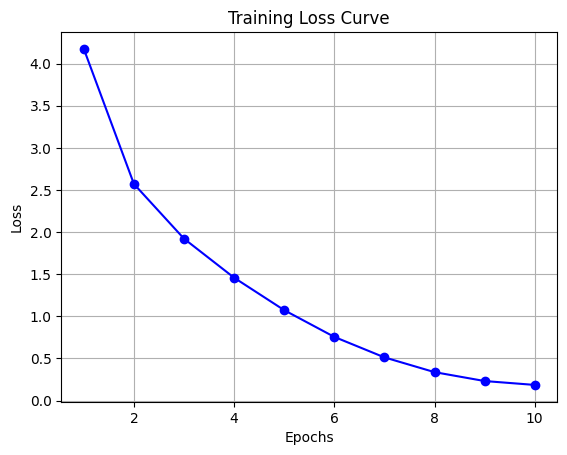

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=50):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.max_len = max_len
        self.register_buffer('pe', self._generate_positional_encoding(d_model, max_len))

    def _generate_positional_encoding(self, d_model, max_len):
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(-torch.arange(0, d_model, 2).float() * (math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)

    def forward(self, x):
        seq_len = x.size(1)  # Get sequence length of input
        # Ensure the positional encoding is generated for the correct sequence length
        if seq_len > self.max_len:
            self.pe = self._generate_positional_encoding(self.d_model, seq_len).to(x.device)
            self.max_len = seq_len
        pe = self.pe[:, :seq_len].to(x.device)  # Use only the required length
        return x + pe



class EncoderLayer(nn.Module):
    def __init__(self, d_model, h, d_ff):
        super(EncoderLayer, self).__init__()
        self.attention = nn.MultiheadAttention(d_model, h)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)

    def forward(self, src):
        attn_output, _ = self.attention(src, src, src)
        src = self.layernorm1(src + attn_output)
        ff_output = self.ffn(src)
        return self.layernorm2(src + ff_output)

class DecoderLayer(nn.Module):
    def __init__(self, d_model, h, d_ff):
        super(DecoderLayer, self).__init__()
        self.attention1 = nn.MultiheadAttention(d_model, h)
        self.attention2 = nn.MultiheadAttention(d_model, h)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)
        self.layernorm3 = nn.LayerNorm(d_model)

    def forward(self, tgt, memory):
        attn_output1, _ = self.attention1(tgt, tgt, tgt)
        tgt = self.layernorm1(tgt + attn_output1)
        attn_output2, _ = self.attention2(tgt, memory, memory)
        tgt = self.layernorm2(tgt + attn_output2)
        ff_output = self.ffn(tgt)
        return self.layernorm3(tgt + ff_output)

class TransformerModel(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, N_e, N_d, d_model, h, d_ff, max_len, src_vocab, tgt_vocab):  # Add src_vocab and tgt_vocab
        super(TransformerModel, self).__init__()

        self.d_model = d_model
        self.src_vocab = src_vocab  # Store the vocabularies
        self.tgt_vocab = tgt_vocab
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)

        self.pos_encoder = PositionalEncoding(d_model, max_len)
        self.pos_decoder = PositionalEncoding(d_model, max_len)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, h, d_ff) for _ in range(N_e)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, h, d_ff) for _ in range(N_d)])

        self.fc_out = nn.Linear(d_model, tgt_vocab_size)

    def forward(self, src, tgt):
        # Clamp sequence length to max_len
        src = src[:, :max_len]
        tgt = tgt[:, :max_len]

        src = self.src_embedding(src) * math.sqrt(self.d_model) # Access d_model using self.d_model
        src = self.pos_encoder(src.permute(1, 0, 2))
        tgt = self.tgt_embedding(tgt) * math.sqrt(self.d_model) # Access d_model using self.d_model
        tgt = self.pos_decoder(tgt.permute(1, 0, 2))

        for layer in self.encoder_layers:
            src = layer(src)

        memory = src

        for layer in self.decoder_layers:
            tgt = layer(tgt, memory)

        output = self.fc_out(tgt.permute(1, 0, 2))  # Back to (batch_size, seq_len, vocab_size)
        return output


    def generate(self, src, max_len=50, start_token="<BOS>", end_token="<EOS>"):
        """
        Generate a sequence from the model using greedy decoding.
        """
        # Convert the input sentence to tensor and move it to the appropriate device
        src_tensor = torch.tensor([src]).to(self.device)  # Assuming 'src' is a list of token indices

        # Initialize the target sequence with the start token
        tgt_tensor = torch.tensor([self.tgt_vocab[start_token]]).unsqueeze(0).to(self.device)  # (1, 1)

        # Generate tokens one by one
        for _ in range(max_len):
            output = self(src_tensor, tgt_tensor)  # Get output from the model
            next_token = output.argmax(dim=-1)[:, -1].item()  # Get the token with highest probability

            if next_token == self.tgt_vocab[end_token]:
                break  # Stop if the end token is generated

            tgt_tensor = torch.cat([tgt_tensor, torch.tensor([[next_token]]).to(self.device)], dim=-1)

        # Convert the token indices to words
        translated_sentence = [self.tgt_vocab.lookup_token(idx) for idx in tgt_tensor.squeeze().cpu().numpy()]



src_vocab_size = len(SRC_VOCAB)
tgt_vocab_size = len(TGT_VOCAB)
N_e = 8
N_d = 8
L = max_len
d = 1024
h = 8
d_ff = 2048

model = TransformerModel(src_vocab_size=src_vocab_size,
                         tgt_vocab_size=tgt_vocab_size,
                         N_e=N_e,
                         N_d=N_d,
                         d_model=d,
                         h=h,
                         d_ff=d_ff,
                         max_len=L,
                         src_vocab=SRC_VOCAB,
                         tgt_vocab=TGT_VOCAB)
model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=SRC_VOCAB['<PAD>'])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


loss_values = []

criterion = nn.CrossEntropyLoss(ignore_index=SRC_VOCAB['<PAD>'])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss_values = []
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for src_batch, tgt_batch in train_loader:
        src_batch = src_batch.to(device)
        tgt_batch = tgt_batch.to(device)

        optimizer.zero_grad()
        src = src_batch
        tgt_input = tgt_batch[:, :-1]
        tgt_output = tgt_batch[:, 1:]

        if src.size(1) > max_len or tgt_input.size(1) > max_len:
            raise ValueError("Sequence length exceeds maximum allowed length.")
        output = model(src, tgt_input)


        loss = criterion(output.view(-1, output.size(-1)), tgt_output.contiguous().view(-1))

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    loss_values.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

plt.plot(range(1, num_epochs + 1), loss_values, marker='o', color='b')
plt.title('Training Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [12]:
import torch
save_path = 'transformer_model.pth'
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to transformer_model.pth


#بخش اختیاری

#تست مدل بر روی داده های تست

In [14]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
def beam_search(decoder, memory, beam_width, max_len, start_token, end_token):
    sequences = [[(list(), 0.0)]]
    for _ in range(max_len):
        all_candidates = []
        for seq, score in sequences[-1]:
            if seq and seq[-1] == end_token:
                all_candidates.append((seq, score))
                continue
            tgt_seq = torch.tensor([seq], device=memory.device)
            output = decoder(tgt_seq, memory)
            logits = output[-1, -1, :]
            probabilities = F.log_softmax(logits, dim=-1)
            top_k = probabilities.topk(beam_width)
            for i, p in zip(top_k.indices, top_k.values):
                candidate = (seq + [i.item()], score + p.item())
                all_candidates.append(candidate)
        ordered = sorted(all_candidates, key=lambda x: x[1], reverse=True)
        sequences.append(ordered[:beam_width])
    return sequences[-1][0][0]

def translate_sentence(sentence, src_vocab, tgt_vocab, model, src_tokenizer, tgt_tokenizer, max_len=50, device='cpu'):
    model.eval()
    model.to(device)

    src_tokens = ['<BOS>'] + src_tokenizer(sentence) + ['<EOS>']
    src_indices = [src_vocab[token] for token in src_tokens]
    src_tensor = torch.tensor(src_indices).unsqueeze(0).to(device)

    tgt_tokens = ['<BOS>']
    tgt_indices = [tgt_vocab['<BOS>']]

    for _ in range(max_len):
        tgt_tensor = torch.tensor(tgt_indices).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(src_tensor, tgt_tensor)
        pred_token_idx = output.argmax(2)[:, -1].item()
        tgt_indices.append(pred_token_idx)
        pred_token = tgt_vocab.get_itos()[pred_token_idx]
        tgt_tokens.append(pred_token)

        if pred_token == '<EOS>':
            break

    return ' '.join(tgt_tokens[1:-1])

def evaluate_model(model, data_loader):
    model.eval()
    references = []
    hypotheses = []
    smoothing_function = SmoothingFunction().method1

    with torch.no_grad():
        for src_batch, tgt_batch in data_loader:
            src_batch = src_batch.to(device)
            tgt_batch = tgt_batch.to(device)
            tgt_input = tgt_batch[:, :-1]

            output = model(src_batch, tgt_input)
            output = output.argmax(dim=-1)

            for i in range(output.size(0)):
                hypotheses.append(
                    [model.tgt_vocab.lookup_token(idx) for idx in output[i].cpu().numpy()]
                )
                references.append(
                    [[model.tgt_vocab.lookup_token(idx) for idx in tgt_batch[i].cpu().numpy() if idx != model.tgt_vocab['<PAD>']]]
                )
                print(f"Hypothesis: {' '.join(hypotheses[-1])}")
                print(f"Reference: {' '.join(references[-1][0])}")

    bleu_score = corpus_bleu(references, hypotheses, smoothing_function=smoothing_function)
    print(f"Smooth BLEU Score: {bleu_score:.4f}")

evaluate_model(model, valid_loader)


Hypothesis: eine gruppe von männern lädt auf auf einen lastwagen <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
Reference: <BOS> eine gruppe von männern lädt baumwolle auf einen lastwagen <EOS>
Hypothesis: ein mann schläft auf einem grünen raum . einem grünen in <EOS> eine schläft schläft schläft schläft schläft schläft schläft schläft schläft schläft schläft schläft schläft schläft schläft schläft schläft schläft schläft schläft schläft schläft schläft schläft schläft schläft schläft schläft schläft schläft schläft schläft schläft schläft schläft schläft
Reference: <BOS> ein mann schläft in einem grünen raum auf einem sofa . <EOS>
Hypothesis: ein junge mit kopfhörern auf auf den schultern einer frau . <EOS> mit sitzt sitzt sitzt sitzt sitzt sitzt sitzt sitzt sitzt sitzt sitzt sitzt sitzt sitzt s